In [2]:
pip -V

pip 25.0 from /users/k23070952/.local/lib/python3.9/site-packages/pip (python 3.9)
Note: you may need to restart the kernel to use updated packages.


In [1]:
cd ~/MultiFidelity-ProcessOpt/Perovskites/

/cephfs/volumes/hpc_home/k23070952/a774a32b-b8f8-42f8-b661-406a5dd49fd8/MultiFidelity-ProcessOpt/Perovskites


In [2]:
from olympus import Surface, Campaign
from atlas.planners.gp.planner import GPPlanner

1


In [3]:
from olympus.datasets import Dataset

In [4]:
#!/usr/bin/env python

import json
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy

from olympus.datasets import Dataset
from olympus.objects import (
	ParameterContinuous,
	ParameterDiscrete, 
	ParameterCategorical, 
	ParameterVector)

from olympus.campaigns import ParameterSpace, Campaign

from atlas.planners.multi_fidelity.planner import MultiFidelityPlanner



In [5]:
# config
dataset = Dataset(kind='perovskites')
NUM_RUNS = 10
# BUDGET = 30
COST_BUDGET = 50 # 200.
NUM_INIT_DESIGN = 10
NUM_CHEAP = 8

# lookup table
# organic --> cation --> anion --> bandgap_hse06/bandgap_gga
LOOKUP = pickle.load(open('0.Data/lookup_table.pkl', 'rb'))
# print(lookup.keys())
# print(lookup['Ethylammonium']['Ge']['F'].keys())



In [6]:
dataset.param_space

In [7]:

def build_options_descriptors(json_file):
	with open(json_file, 'r') as f:
		content = json.load(f)

	options = list(content.keys())
	descriptors = [list(content[opt].values()) for opt in options]

	return options, descriptors

def measure(params, s):
	# high-fidelity is hse06, low-fidelity is gga
	if s == 1.0:
		measurement = np.amin(
			LOOKUP[params.organic.capitalize()][params.cation][params.anion]['bandgap_hse06']
		)
	elif s == 0.1:
		measurement = np.amin(
			LOOKUP[params.organic.capitalize()][params.cation][params.anion]['bandgap_gga']
		)
	return measurement

def get_min_hse06_bandgap(param_space):
	organic_options = [o.capitalize() for o in param_space[1].options]
	cation_options = [o.capitalize() for o in param_space[2].options]
	anion_options = [o.capitalize() for o in param_space[3].options]

	hse06_bandgaps = []
	for organic_option in organic_options:
		for cation_option in cation_options:
			for anion_option in anion_options:
				hse06_bandgaps.append(
					np.amin(
						LOOKUP[organic_option][cation_option][anion_option]['bandgap_hse06']
					)
				)
	min_hse06_bandgap = np.amin(hse06_bandgaps)
	return min_hse06_bandgap

def compute_cost(params):
	costs = params[:,0].astype(float)
	return np.sum(costs)



In [8]:

# build parameter space
param_space = ParameterSpace()

# fidelity param
param_space.add(ParameterDiscrete(name='s', options=[0.1, 1.0], low=0.1, high=1.0))
for param in dataset.param_space: # add perovskite component parameters ('organic', 'cation', and 'anion')
	print(param)
	param_space.add(param)


all_data = []
min_hse06_bandgap = get_min_hse06_bandgap(param_space)
print('MIN HSE06 BANDGAP : ', min_hse06_bandgap)
# >>> MIN HSE06 BANDGAP :  1.5249
# hydrazinium	Sn	I



Categorical (name='organic', num_opts: 16, options=['ethylammonium', 'propylammonium', 'butylammonium', 'isopropylammonium', 'dimethylammonium', 'acetamidinium', 'methylammonium', 'guanidinium', 'hydroxylammonium', 'formamidinium', 'tetramethylammonium', 'hydrazinium', 'ammonium', 'trimethylammonium', 'azetidinium', 'imidazolium'], descriptors=[[-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.22397999465465

In [9]:
import time

timing_data = []
for run_ix in range(NUM_RUNS):

	campaign = Campaign()
	campaign.set_param_space(param_space)

	planner = MultiFidelityPlanner(
		goal='minimize',
		init_design_strategy='random',
		num_init_design=NUM_INIT_DESIGN,
		use_descriptors=True,
		batch_size=1,
		acquisition_optimizer_kind='pymoo',
		fidelity_params=0,
		fidelities=[0.1, 1.],
	)

	planner.set_param_space(param_space)

	COST = 0.

	target_rec_measurements = []
	iter_ = 0
	while COST < COST_BUDGET:
		print(f'\nRUN : {run_ix+1}/{NUM_RUNS}\tITER : {iter_+1}\tCOST : {COST}\n')
		start_time = time.time()  # 시작 시간 저장
		if iter_ % NUM_CHEAP == 0:
			planner.set_ask_fidelity(1.0)
		else:
			planner.set_ask_fidelity(0.1)

		samples = planner.recommend(campaign.observations)
		end_time = time.time()  # 시작 시간 저장
		time_taken = end_time-start_time
		print(f"Time: {time_taken}s")
		
		timing_data.append([run_ix, iter_, time_taken])
		for sample in samples:
			measurement = measure(sample, sample.s)
			campaign.add_observation(sample, measurement)

			print('SAMPLE : ', sample)
			print('MEASUREMENT : ', measurement)

			iter_+=1

		# do a check to see if model will find the optimal
		if campaign.num_obs > NUM_INIT_DESIGN:
			# make greedy recommendation on the target fidelity
			rec_sample = planner.recommend_target_fidelity(batch_size=1)[0]
			rec_measurement = measure(rec_sample, rec_sample.s)
			print('')
			print('REC SAMPLE : ', rec_sample)
			print('REC MEASUREMENT : ', rec_measurement)
			print('')
			target_rec_measurements.append(rec_measurement)
			# kill the run if we have found the lowest hse06 bandgap
			# on the most recent high-fidelity measurement
			if rec_measurement == min_hse06_bandgap:
				print('found the min hse06 bandgap!')
				break
		else:
			target_rec_measurements.append(measurement)
			# kill the run if we have found the lowest hse06 bandgap
			# on the most recent high-fidelity measurement
			if measurement == min_hse06_bandgap and samples[0].s == 1.:
				print('found the min hse06 bandgap!')
				break

		
		COST = compute_cost(params=campaign.observations.get_params())



	s_col = campaign.observations.get_params()[:, 0]
	x0_col = campaign.observations.get_params()[:, 1]
	x1_col = campaign.observations.get_params()[:, 2]
	x2_col = campaign.observations.get_params()[:, 3]

	obj0_col = np.array(target_rec_measurements) #campaign.observations.get_values()

	data = pd.DataFrame({
		's': s_col,
		'organic': x0_col,
		'cation': x1_col,
		'anion': x2_col,
		'obj': obj0_col,
	})
	all_data.append(data)
	pickle.dump(all_data, open('mf_results.pkl', 'wb'))

timing_df = pd.DataFrame(timing_data, columns=['run_ix', 'iter', 'time_taken'])
timing_df.to_csv('timing_results.csv', index=False)

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────


RUN : 1/10	ITER : 1	COST : 0.0



ATLAS [WARNING] Setting ask fidelity level to 1.0

ATLAS [INFO] Generating 1 initial design points (batch 1/10)

Time: 0.013117074966430664s
SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  4.0419

RUN : 1/10	ITER : 2	COST : 1.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 2/10)

Time: 0.013698101043701172s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.1972

RUN : 1/10	ITER : 3	COST : 1.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 3/10)

Time: 0.013181924819946289s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.7006

RUN : 1/10	ITER : 4	COST : 1.2000000000000002



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 4/10)

Time: 0.01229238510131836s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Sn, anion = Cl)
MEASUREMENT :  1.9365

RUN : 1/10	ITER : 5	COST : 1.3000000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 5/10)

Time: 0.012480020523071289s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.2759

RUN : 1/10	ITER : 6	COST : 1.4000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 6/10)

Time: 0.01220083236694336s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3041

RUN : 1/10	ITER : 7	COST : 1.5000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 7/10)

Time: 0.012128829956054688s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.7441

RUN : 1/10	ITER : 8	COST : 1.6000000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 8/10)

Time: 0.011618375778198242s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Sn, anion = Cl)
MEASUREMENT :  2.267

RUN : 1/10	ITER : 9	COST : 1.7000000000000002



ATLAS [WARNING] Setting ask fidelity level to 1.0

ATLAS [INFO] Generating 1 initial design points (batch 9/10)

Time: 0.011579036712646484s
SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Ge, anion = I)
MEASUREMENT :  2.5369

RUN : 1/10	ITER : 10	COST : 2.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 10/10)

Time: 0.011173009872436523s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.7324

RUN : 1/10	ITER : 11	COST : 2.8000000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4425e-16]), std = tensor([1.0541])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.314 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5036342144012451s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Sn, anion = F)
MEASUREMENT :  2.6833


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.6967


RUN : 1/10	ITER : 12	COST : 2.9000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0093e-16]), std = tensor([1.0488])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.165 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.094541072845459s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Ge, anion = Cl)
MEASUREMENT :  1.7931


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.3311


RUN : 1/10	ITER : 13	COST : 3.0000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1102e-16]), std = tensor([1.0445])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.129 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.0324859619140625s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Ge, anion = Br)
MEASUREMENT :  2.091


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.4152


RUN : 1/10	ITER : 14	COST : 3.1000000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.4409e-16]), std = tensor([1.0408])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.126 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.143101692199707s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.5974


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.6158


RUN : 1/10	ITER : 15	COST : 3.2000000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.0753e-16]), std = tensor([1.0377])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.169 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.0801217555999756s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.607


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.3986


RUN : 1/10	ITER : 16	COST : 3.3000000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.7007e-16]), std = tensor([1.0351])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.211 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.188258171081543s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Pb, anion = F)
MEASUREMENT :  4.137


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.0922


RUN : 1/10	ITER : 17	COST : 3.4000000000000004



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.1919e-16]), std = tensor([1.0328])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.14 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.194058895111084s
SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Ge, anion = F)
MEASUREMENT :  5.5243


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.183


RUN : 1/10	ITER : 18	COST : 4.4



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.1347e-16]), std = tensor([1.0308])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.154 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.2991862297058105s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.546


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.1528


RUN : 1/10	ITER : 19	COST : 4.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6391e-16]), std = tensor([1.0290])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.236 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5007398128509521s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Pb, anion = F)
MEASUREMENT :  4.3054


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.7138


RUN : 1/10	ITER : 20	COST : 4.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.6680e-16]), std = tensor([1.0274])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.254 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.6398446559906006s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = I)
MEASUREMENT :  1.6986


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Sn, anion = I)
REC MEASUREMENT :  2.3071


RUN : 1/10	ITER : 21	COST : 4.699999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.8842e-16]), std = tensor([1.0260])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.28 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5326509475708008s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = F)
MEASUREMENT :  3.8145


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  4.2964


RUN : 1/10	ITER : 22	COST : 4.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.2778e-16]), std = tensor([1.0247])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.183 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7463512420654297s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Sn, anion = I)
MEASUREMENT :  1.2292


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.8004


RUN : 1/10	ITER : 23	COST : 4.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6428e-16]), std = tensor([1.0235])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.18 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.4558196067810059s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Pb, anion = Br)
MEASUREMENT :  1.8768


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.1209


RUN : 1/10	ITER : 24	COST : 4.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.2204e-16]), std = tensor([1.0225])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.156 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.4058382511138916s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.7221


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  3.569


RUN : 1/10	ITER : 25	COST : 5.1



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-9.2519e-18]), std = tensor([1.0215])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.252 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5707502365112305s
SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Pb, anion = I)
MEASUREMENT :  2.5415


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  3.1891


RUN : 1/10	ITER : 26	COST : 6.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.]), std = tensor([1.0206])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.166 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5788953304290771s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.674


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.7579


RUN : 1/10	ITER : 27	COST : 6.199999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.7934e-16]), std = tensor([1.0198])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.169 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7565441131591797s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.3686


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.7716


RUN : 1/10	ITER : 28	COST : 6.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.3027e-16]), std = tensor([1.0190])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.246 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.6304948329925537s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = F)
MEASUREMENT :  4.4245


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.7596


RUN : 1/10	ITER : 29	COST : 6.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-7.9302e-18]), std = tensor([1.0184])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.128 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.4312903881072998s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Pb, anion = F)
MEASUREMENT :  3.3606


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.7128


RUN : 1/10	ITER : 30	COST : 6.499999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.4455e-16]), std = tensor([1.0177])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.168 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5945658683776855s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Sn, anion = F)
MEASUREMENT :  3.8681


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.6967


RUN : 1/10	ITER : 31	COST : 6.599999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.2583e-16]), std = tensor([1.0171])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.168 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7362644672393799s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Sn, anion = F)
MEASUREMENT :  4.4999


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.1218


RUN : 1/10	ITER : 32	COST : 6.6999999999999975



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.0056e-16]), std = tensor([1.0165])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.15 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.852994680404663s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Sn, anion = F)
MEASUREMENT :  3.2677


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  3.9789


RUN : 1/10	ITER : 33	COST : 6.800000000000001



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([7.6328e-17]), std = tensor([1.0160])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.175 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.6565372943878174s
SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  3.8219


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.0364


RUN : 1/10	ITER : 34	COST : 7.800000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.7100e-17]), std = tensor([1.0155])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.164 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.6987991333007812s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Sn, anion = Br)
MEASUREMENT :  2.0577


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Ge, anion = F)
REC MEASUREMENT :  4.5246


RUN : 1/10	ITER : 35	COST : 7.9



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4613e-16]), std = tensor([1.0150])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.175 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5908777713775635s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Pb, anion = F)
MEASUREMENT :  3.2919


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Ge, anion = F)
REC MEASUREMENT :  4.5246


RUN : 1/10	ITER : 36	COST : 8.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2688e-17]), std = tensor([1.0146])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.143 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7294573783874512s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.9921


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Pb, anion = F)
REC MEASUREMENT :  4.8007


RUN : 1/10	ITER : 37	COST : 8.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4055e-16]), std = tensor([1.0142])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.15 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0054235458374023s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Ge, anion = I)
MEASUREMENT :  1.3701


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.424


RUN : 1/10	ITER : 38	COST : 8.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.4011e-16]), std = tensor([1.0138])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.22 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9081430435180664s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Sn, anion = Br)
MEASUREMENT :  1.7216


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.8001


RUN : 1/10	ITER : 39	COST : 8.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([7.7716e-16]), std = tensor([1.0134])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.151 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7396533489227295s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.0807


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Ge, anion = I)
REC MEASUREMENT :  1.9667


RUN : 1/10	ITER : 40	COST : 8.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.6935e-16]), std = tensor([1.0131])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.238 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9657795429229736s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.7495


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.3003


RUN : 1/10	ITER : 41	COST : 8.5



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.2204e-16]), std = tensor([1.0127])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.395 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8144190311431885s
SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Pb, anion = Cl)
MEASUREMENT :  3.2914


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.293


RUN : 1/10	ITER : 42	COST : 9.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0076e-16]), std = tensor([1.0124])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.245 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7889916896820068s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Pb, anion = I)
MEASUREMENT :  1.5309


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.6193


RUN : 1/10	ITER : 43	COST : 9.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0574e-16]), std = tensor([1.0121])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.386 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.176547050476074s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.9443


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.2463


RUN : 1/10	ITER : 44	COST : 9.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8729e-16]), std = tensor([1.0118])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.265 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0548136234283447s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.2713


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.7575


RUN : 1/10	ITER : 45	COST : 9.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1102e-16]), std = tensor([1.0116])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.255 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3382105827331543s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = Br)
MEASUREMENT :  1.8833


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Pb, anion = F)
REC MEASUREMENT :  4.8007


RUN : 1/10	ITER : 46	COST : 9.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.7764e-16]), std = tensor([1.0113])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.156 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.085935354232788s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Pb, anion = F)
MEASUREMENT :  3.7441


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  4.8213


RUN : 1/10	ITER : 47	COST : 9.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.3170e-16]), std = tensor([1.0111])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.225 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.075448989868164s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Sn, anion = F)
MEASUREMENT :  3.3117


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.1393


RUN : 1/10	ITER : 48	COST : 10.099999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-9.4487e-18]), std = tensor([1.0108])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.352 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.300384521484375s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Pb, anion = Cl)
MEASUREMENT :  2.5692


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.7839


RUN : 1/10	ITER : 49	COST : 10.2



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.7293e-16]), std = tensor([1.0106])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.34 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.118345260620117s
SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = I)
MEASUREMENT :  2.3129


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.0581


RUN : 1/10	ITER : 50	COST : 11.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([6.7973e-17]), std = tensor([1.0104])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.176 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8124690055847168s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.378


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.9218


RUN : 1/10	ITER : 51	COST : 11.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.3323e-16]), std = tensor([1.0102])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.3 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.1530466079711914s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.5228


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.312


RUN : 1/10	ITER : 52	COST : 11.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.147 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9935379028320312s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Sn, anion = F)
MEASUREMENT :  3.2079


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.4425


RUN : 1/10	ITER : 53	COST : 11.499999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.225 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.090494155883789s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  1.4646


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.3704


RUN : 1/10	ITER : 54	COST : 11.599999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.221 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.133216619491577s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.9845


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.76


RUN : 1/10	ITER : 55	COST : 11.699999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.215 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.9399607181549072s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.9327


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.2463


RUN : 1/10	ITER : 56	COST : 11.799999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.219 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.906306505203247s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.4809


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Sn, anion = I)
REC MEASUREMENT :  1.5618


RUN : 1/10	ITER : 57	COST : 11.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.171 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8456599712371826s
SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Pb, anion = Br)
MEASUREMENT :  2.8641


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.7591


RUN : 1/10	ITER : 58	COST : 12.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.186 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8673040866851807s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  2.891


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.8815


RUN : 1/10	ITER : 59	COST : 12.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.193 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.248934745788574s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.2672


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  1.9695


RUN : 1/10	ITER : 60	COST : 13.099999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.178 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.265922784805298s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Pb, anion = F)
MEASUREMENT :  3.3949


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.76


RUN : 1/10	ITER : 61	COST : 13.199999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.308 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.47462797164917s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Sn, anion = F)
MEASUREMENT :  2.8795


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.1431


RUN : 1/10	ITER : 62	COST : 13.299999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.324 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.6056604385375977s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.383


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.8061


RUN : 1/10	ITER : 63	COST : 13.399999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.154 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.339090585708618s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.9164


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.8061


RUN : 1/10	ITER : 64	COST : 13.499999999999996



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.144 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.090862989425659s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.3516


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  2.8141


RUN : 1/10	ITER : 65	COST : 13.6



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.216 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3096790313720703s
SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Sn, anion = F)
MEASUREMENT :  4.4118


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.8012


RUN : 1/10	ITER : 66	COST : 14.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.213 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.107840061187744s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Pb, anion = Br)
MEASUREMENT :  1.6915


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.4192


RUN : 1/10	ITER : 67	COST : 14.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.208 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.2289936542510986s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Pb, anion = I)
MEASUREMENT :  1.6258


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Ge, anion = I)
REC MEASUREMENT :  2.2305


RUN : 1/10	ITER : 68	COST : 14.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.168 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.444514036178589s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.5224


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.9083


RUN : 1/10	ITER : 69	COST : 14.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.188 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3229620456695557s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  2.2048


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.293


RUN : 1/10	ITER : 70	COST : 14.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.206 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.416584014892578s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.9523


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.1528


RUN : 1/10	ITER : 71	COST : 15.099999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.21 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3380544185638428s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.8825


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.186


RUN : 1/10	ITER : 72	COST : 15.199999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.193 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.451737403869629s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Sn, anion = Br)
MEASUREMENT :  2.3568


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.9218


RUN : 1/10	ITER : 73	COST : 15.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.172 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.585876941680908s
SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Sn, anion = F)
MEASUREMENT :  5.6831


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Sn, anion = I)
REC MEASUREMENT :  1.5849


RUN : 1/10	ITER : 74	COST : 16.299999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.253 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.492405652999878s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = Cl)
MEASUREMENT :  2.8878


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.3812


RUN : 1/10	ITER : 75	COST : 16.4



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.242 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.4506964683532715s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.3129


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  2.0718


RUN : 1/10	ITER : 76	COST : 16.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.167 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.2806921005249023s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3754


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.4677


RUN : 1/10	ITER : 77	COST : 16.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.18 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.339576244354248s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Sn, anion = F)
MEASUREMENT :  2.8524


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.5038


RUN : 1/10	ITER : 78	COST : 16.700000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.212 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.577723741531372s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.9253


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.9374


RUN : 1/10	ITER : 79	COST : 16.800000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.204 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3687360286712646s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Sn, anion = Cl)
MEASUREMENT :  2.5824


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.452


RUN : 1/10	ITER : 80	COST : 16.900000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.245 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.4888393878936768s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Sn, anion = I)
MEASUREMENT :  1.0637


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.9974


RUN : 1/10	ITER : 81	COST : 17.0



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.214 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.39432430267334s
SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Sn, anion = Br)
MEASUREMENT :  2.3986


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.9553


RUN : 1/10	ITER : 82	COST : 18.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.247 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.5158464908599854s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3229


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.0922


RUN : 1/10	ITER : 83	COST : 18.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.238 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.650189161300659s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  3.1237


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  1.7969


RUN : 1/10	ITER : 84	COST : 18.200000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.233 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.5302646160125732s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.4025


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = F)
REC MEASUREMENT :  3.985


RUN : 1/10	ITER : 85	COST : 18.300000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.242 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.709902048110962s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = Br)
MEASUREMENT :  2.2149


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.162


RUN : 1/10	ITER : 86	COST : 18.400000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.245 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.848404884338379s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Sn, anion = Br)
MEASUREMENT :  1.3702


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.8061


RUN : 1/10	ITER : 87	COST : 18.500000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.211 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.7681665420532227s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.9361


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  3.1891


RUN : 1/10	ITER : 88	COST : 18.60000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.265 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.7001166343688965s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Pb, anion = Br)
MEASUREMENT :  2.3859


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.9861


RUN : 1/10	ITER : 89	COST : 18.7



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.266 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.684830904006958s
SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = I)
MEASUREMENT :  2.6193


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.3704


RUN : 1/10	ITER : 90	COST : 19.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.363 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.3566532135009766s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.1513


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.1218


RUN : 1/10	ITER : 91	COST : 19.8



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.318 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.8986661434173584s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.1048


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.452


RUN : 1/10	ITER : 92	COST : 19.900000000000002



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.2 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.6031694412231445s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = Cl)
MEASUREMENT :  2.6892


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  1.9695


RUN : 1/10	ITER : 93	COST : 20.000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.208 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.863574743270874s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Sn, anion = Br)
MEASUREMENT :  1.4178


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.5838


RUN : 1/10	ITER : 94	COST : 20.100000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.221 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.690021514892578s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = Br)
MEASUREMENT :  1.6643


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  1.9695


RUN : 1/10	ITER : 95	COST : 20.200000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.226 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.7008862495422363s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = I)
MEASUREMENT :  1.4519


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  6.3242


RUN : 1/10	ITER : 96	COST : 20.300000000000008



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.212 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.689409017562866s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Ge, anion = F)
MEASUREMENT :  3.7949


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.7596


RUN : 1/10	ITER : 97	COST : 20.4



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.229 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.7440195083618164s
SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.7969


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.7624


RUN : 1/10	ITER : 98	COST : 21.4



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.206 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.8253250122070312s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.5966


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.7716


RUN : 1/10	ITER : 99	COST : 21.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.277 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.9214956760406494s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.8234


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.5517


RUN : 1/10	ITER : 100	COST : 21.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.327 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.186924695968628s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Sn, anion = F)
MEASUREMENT :  3.2593


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.5905


RUN : 1/10	ITER : 101	COST : 21.700000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.474 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.324838161468506s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  3.5046


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.0581


RUN : 1/10	ITER : 102	COST : 21.800000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.405 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.4250948429107666s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.0009


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Sn, anion = F)
REC MEASUREMENT :  3.8529


RUN : 1/10	ITER : 103	COST : 21.900000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.21 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.139122247695923s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Sn, anion = F)
MEASUREMENT :  2.6688


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.7579


RUN : 1/10	ITER : 104	COST : 22.000000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.406 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.2831108570098877s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  3.0774


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Ge, anion = I)
REC MEASUREMENT :  2.0923


RUN : 1/10	ITER : 105	COST : 22.1



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.218 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1361520290374756s
SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = I)
MEASUREMENT :  1.9179


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.3311


RUN : 1/10	ITER : 106	COST : 23.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.227 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.0638680458068848s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Pb, anion = Br)
MEASUREMENT :  1.913


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.4811


RUN : 1/10	ITER : 107	COST : 23.200000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.405 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.2383172512054443s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = F)
MEASUREMENT :  3.925


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.8697


RUN : 1/10	ITER : 108	COST : 23.300000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.245 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1307764053344727s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  1.9337


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.7591


RUN : 1/10	ITER : 109	COST : 23.400000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.222 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1353414058685303s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Sn, anion = I)
MEASUREMENT :  1.0554


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.183


RUN : 1/10	ITER : 110	COST : 23.500000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.199 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.151676654815674s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Pb, anion = I)
MEASUREMENT :  1.5862


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.7596


RUN : 1/10	ITER : 111	COST : 23.60000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.205 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1276118755340576s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.6032


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.4088


RUN : 1/10	ITER : 112	COST : 23.70000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.216 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1345767974853516s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.4083


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.7716


RUN : 1/10	ITER : 113	COST : 23.8



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.206 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.284545660018921s
SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Sn, anion = I)
MEASUREMENT :  2.0718


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.6438


RUN : 1/10	ITER : 114	COST : 24.8



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.213 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.266329050064087s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  2.0343


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.7138


RUN : 1/10	ITER : 115	COST : 24.900000000000002



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.228 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.3106260299682617s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  1.5692


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.1762


RUN : 1/10	ITER : 116	COST : 25.000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.262 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.317128896713257s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Sn, anion = I)
MEASUREMENT :  1.7199


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  4.4938


RUN : 1/10	ITER : 117	COST : 25.100000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.218 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.336732864379883s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Ge, anion = F)
MEASUREMENT :  3.2258


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  6.0254


RUN : 1/10	ITER : 118	COST : 25.200000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.262 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.3947842121124268s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Pb, anion = Br)
MEASUREMENT :  2.0313


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.7591


RUN : 1/10	ITER : 119	COST : 25.300000000000008



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.256 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.4229013919830322s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.3945


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.3424


RUN : 1/10	ITER : 120	COST : 25.40000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.19 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.3542673587799072s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Sn, anion = F)
MEASUREMENT :  3.2736


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  2.0056


RUN : 1/10	ITER : 121	COST : 25.5



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.264 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.4993584156036377s
SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Pb, anion = F)
MEASUREMENT :  5.3311


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Sn, anion = I)
REC MEASUREMENT :  1.5249

found the min hse06 bandgap!


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────


RUN : 2/10	ITER : 1	COST : 0.0



ATLAS [WARNING] Setting ask fidelity level to 1.0

ATLAS [INFO] Generating 1 initial design points (batch 1/10)

Time: 0.0058896541595458984s
SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Pb, anion = Cl)
MEASUREMENT :  3.7383

RUN : 2/10	ITER : 2	COST : 1.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 2/10)

Time: 0.006470918655395508s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = Br)
MEASUREMENT :  1.8833

RUN : 2/10	ITER : 3	COST : 1.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 3/10)

Time: 0.006416797637939453s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.674

RUN : 2/10	ITER : 4	COST : 1.2000000000000002



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 4/10)

Time: 0.00654149055480957s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Sn, anion = Br)
MEASUREMENT :  1.4078

RUN : 2/10	ITER : 5	COST : 1.3000000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 5/10)

Time: 0.006732463836669922s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.3516

RUN : 2/10	ITER : 6	COST : 1.4000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 6/10)

Time: 0.006809234619140625s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.0807

RUN : 2/10	ITER : 7	COST : 1.5000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 7/10)

Time: 0.00693964958190918s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = F)
MEASUREMENT :  3.8145

RUN : 2/10	ITER : 8	COST : 1.6000000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 8/10)

Time: 0.0069561004638671875s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Ge, anion = I)
MEASUREMENT :  1.9956

RUN : 2/10	ITER : 9	COST : 1.7000000000000002



ATLAS [WARNING] Setting ask fidelity level to 1.0

ATLAS [INFO] Generating 1 initial design points (batch 9/10)

Time: 0.0069615840911865234s
SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Pb, anion = I)
MEASUREMENT :  2.4541

RUN : 2/10	ITER : 10	COST : 2.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 10/10)

Time: 0.007163047790527344s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  2.7957

RUN : 2/10	ITER : 11	COST : 2.8000000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-8.8818e-17]), std = tensor([1.0541])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.104 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 0.9624168872833252s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Pb, anion = Br)
MEASUREMENT :  1.8768


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.8219


RUN : 2/10	ITER : 12	COST : 2.9000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-4.0372e-17]), std = tensor([1.0488])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.121 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 0.979724645614624s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.6555


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Sn, anion = Br)
REC MEASUREMENT :  1.909


RUN : 2/10	ITER : 13	COST : 3.0000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.]), std = tensor([1.0445])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.099 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 0.9635417461395264s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Ge, anion = Br)
MEASUREMENT :  1.5009


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Sn, anion = I)
REC MEASUREMENT :  2.3071


RUN : 2/10	ITER : 14	COST : 3.1000000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.3912e-16]), std = tensor([1.0408])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.134 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.0245375633239746s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.6076


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = F)
REC MEASUREMENT :  4.7658


RUN : 2/10	ITER : 15	COST : 3.2000000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.0618e-16]), std = tensor([1.0377])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.116 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.0138695240020752s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Ge, anion = Cl)
MEASUREMENT :  2.7072


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.7773


RUN : 2/10	ITER : 16	COST : 3.3000000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6645e-16]), std = tensor([1.0351])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.128 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.0436151027679443s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Sn, anion = Cl)
MEASUREMENT :  1.9365


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.9374


RUN : 2/10	ITER : 17	COST : 3.4000000000000004



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.7756e-17]), std = tensor([1.0328])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.14 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.188286542892456s
SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = F)
MEASUREMENT :  4.4192


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.7596


RUN : 2/10	ITER : 18	COST : 4.4



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.3511e-16]), std = tensor([1.0308])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.16 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.3256959915161133s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.7405


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.1098


RUN : 2/10	ITER : 19	COST : 4.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.2204e-16]), std = tensor([1.0290])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.236 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.3981289863586426s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.0366


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.7138


RUN : 2/10	ITER : 20	COST : 4.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.6361e-16]), std = tensor([1.0274])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.2 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.4080209732055664s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.8234


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Ge, anion = F)
REC MEASUREMENT :  4.5246


RUN : 2/10	ITER : 21	COST : 4.699999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.6653e-16]), std = tensor([1.0260])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.141 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.3669092655181885s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.3272


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.5038


RUN : 2/10	ITER : 22	COST : 4.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.6040e-16]), std = tensor([1.0247])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.136 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.364382028579712s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = I)
MEASUREMENT :  1.6986


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.4104


RUN : 2/10	ITER : 23	COST : 4.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.2390e-16]), std = tensor([1.0235])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.291 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.519972324371338s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.1475


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.8012


RUN : 2/10	ITER : 24	COST : 4.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([6.6613e-16]), std = tensor([1.0225])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.276 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5328986644744873s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.6041


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.8535


RUN : 2/10	ITER : 25	COST : 5.1



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.4980e-16]), std = tensor([1.0215])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.199 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.4972150325775146s
SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Ge, anion = I)
MEASUREMENT :  2.0923


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.7716


RUN : 2/10	ITER : 26	COST : 6.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.4639e-16]), std = tensor([1.0206])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.204 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.4974215030670166s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Sn, anion = F)
MEASUREMENT :  2.8524


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.0581


RUN : 2/10	ITER : 27	COST : 6.199999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-4.5263e-16]), std = tensor([1.0198])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.186 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.5466158390045166s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.1972


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.7128


RUN : 2/10	ITER : 28	COST : 6.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.9475e-16]), std = tensor([1.0190])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.245 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9114646911621094s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Sn, anion = F)
MEASUREMENT :  3.6043


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.293


RUN : 2/10	ITER : 29	COST : 6.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-5.4520e-16]), std = tensor([1.0184])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.121 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.6121232509613037s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Pb, anion = I)
MEASUREMENT :  1.8533


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Pb, anion = I)
REC MEASUREMENT :  2.4574


RUN : 2/10	ITER : 30	COST : 6.499999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-6.6231e-16]), std = tensor([1.0177])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.218 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.6030158996582031s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  1.9337


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.5456


RUN : 2/10	ITER : 31	COST : 6.599999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-8.3267e-16]), std = tensor([1.0171])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.235 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.4999971389770508s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Ge, anion = F)
MEASUREMENT :  3.7949


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.1552


RUN : 2/10	ITER : 32	COST : 6.6999999999999975



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-7.4313e-16]), std = tensor([1.0165])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.187 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.845144271850586s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.6468


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Pb, anion = I)
REC MEASUREMENT :  2.3586


RUN : 2/10	ITER : 33	COST : 6.800000000000001



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.3878e-17]), std = tensor([1.0160])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.223 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8384888172149658s
SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = F)
MEASUREMENT :  4.7658


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.844


RUN : 2/10	ITER : 34	COST : 7.800000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.]), std = tensor([1.0155])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.306 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0473973751068115s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Ge, anion = F)
MEASUREMENT :  4.0646


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Pb, anion = F)
REC MEASUREMENT :  5.5121


RUN : 2/10	ITER : 35	COST : 7.9



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0694e-16]), std = tensor([1.0150])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.194 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.035809278488159s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Ge, anion = Br)
MEASUREMENT :  2.091


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Pb, anion = F)
REC MEASUREMENT :  5.5121


RUN : 2/10	ITER : 36	COST : 8.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.3291e-16]), std = tensor([1.0146])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.141 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9625940322875977s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3754


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.8957


RUN : 2/10	ITER : 37	COST : 8.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.1810e-16]), std = tensor([1.0142])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.127 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7255985736846924s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  2.891


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.9713


RUN : 2/10	ITER : 38	COST : 8.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8604e-16]), std = tensor([1.0138])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.162 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.813408374786377s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Pb, anion = I)
MEASUREMENT :  2.0452


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.9713


RUN : 2/10	ITER : 39	COST : 8.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.8048e-16]), std = tensor([1.0134])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.295 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8821282386779785s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.9253


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.5014


RUN : 2/10	ITER : 40	COST : 8.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.9854e-16]), std = tensor([1.0131])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.274 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9247431755065918s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = Br)
MEASUREMENT :  2.2149


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.186


RUN : 2/10	ITER : 41	COST : 8.5



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([9.9920e-17]), std = tensor([1.0127])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.21 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8971586227416992s
SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = Br)
MEASUREMENT :  3.569


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.7591


RUN : 2/10	ITER : 42	COST : 9.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.6247e-17]), std = tensor([1.0124])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.169 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7925641536712646s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.6871


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.3704


RUN : 2/10	ITER : 43	COST : 9.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-5.2868e-17]), std = tensor([1.0121])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.182 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8695297241210938s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.4002


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  3.9789


RUN : 2/10	ITER : 44	COST : 9.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6474e-17]), std = tensor([1.0118])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.295 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0221774578094482s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Pb, anion = F)
MEASUREMENT :  3.7441


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Ge, anion = F)
REC MEASUREMENT :  4.9157


RUN : 2/10	ITER : 45	COST : 9.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([5.5511e-17]), std = tensor([1.0116])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.168 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.8473742008209229s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.5966


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.9553


RUN : 2/10	ITER : 46	COST : 9.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.9737e-17]), std = tensor([1.0113])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.158 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.7318751811981201s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.4624


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.6158


RUN : 2/10	ITER : 47	COST : 9.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.5929e-16]), std = tensor([1.0111])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.194 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0690250396728516s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Pb, anion = F)
MEASUREMENT :  4.1478


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Pb, anion = F)
REC MEASUREMENT :  5.0782


RUN : 2/10	ITER : 48	COST : 10.099999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.9842e-16]), std = tensor([1.0108])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.171 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9813449382781982s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Ge, anion = I)
MEASUREMENT :  1.7434


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.0922


RUN : 2/10	ITER : 49	COST : 10.2



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-7.4015e-17]), std = tensor([1.0106])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.173 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.102102518081665s
SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.9713


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = I)
REC MEASUREMENT :  2.3181


RUN : 2/10	ITER : 50	COST : 11.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([9.9693e-17]), std = tensor([1.0104])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.302 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0985958576202393s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.163


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.8626


RUN : 2/10	ITER : 51	COST : 11.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2879e-16]), std = tensor([1.0102])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.21 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0945777893066406s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  3.1237


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  2.5629


RUN : 2/10	ITER : 52	COST : 11.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.217 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.052030086517334s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Ge, anion = Cl)
MEASUREMENT :  1.7931


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  4.1047


RUN : 2/10	ITER : 53	COST : 11.499999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.192 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.1607162952423096s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.4025


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.9855


RUN : 2/10	ITER : 54	COST : 11.599999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.294 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.163630723953247s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = I)
MEASUREMENT :  1.4519


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.2155


RUN : 2/10	ITER : 55	COST : 11.699999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.294 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.304741621017456s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Ge, anion = F)
MEASUREMENT :  3.5371


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Sn, anion = Br)
REC MEASUREMENT :  1.909


RUN : 2/10	ITER : 56	COST : 11.799999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.305 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3207309246063232s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.9361


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.2931


RUN : 2/10	ITER : 57	COST : 11.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.185 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.2178657054901123s
SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Pb, anion = Br)
MEASUREMENT :  3.186


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.4124


RUN : 2/10	ITER : 58	COST : 12.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.146 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0442333221435547s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Sn, anion = Cl)
MEASUREMENT :  1.8717


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.8957


RUN : 2/10	ITER : 59	COST : 12.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.152 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 1.9395534992218018s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.5224


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.2969


RUN : 2/10	ITER : 60	COST : 13.099999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.178 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.0360031127929688s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3908


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Ge, anion = I)
REC MEASUREMENT :  1.8829


RUN : 2/10	ITER : 61	COST : 13.199999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.159 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.46909761428833s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.1513


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.3492


RUN : 2/10	ITER : 62	COST : 13.299999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.192 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.125091552734375s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  1.4646


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.2569


RUN : 2/10	ITER : 63	COST : 13.399999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.362 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3927245140075684s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Pb, anion = F)
MEASUREMENT :  2.8657


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.4313


RUN : 2/10	ITER : 64	COST : 13.499999999999996



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.251 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.257272243499756s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.8612


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  4.4938


RUN : 2/10	ITER : 65	COST : 13.6



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.329 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.431751012802124s
SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = Cl)
MEASUREMENT :  3.293


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = I)
REC MEASUREMENT :  1.9179


RUN : 2/10	ITER : 66	COST : 14.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.256 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3288815021514893s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  3.5046


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Pb, anion = I)
REC MEASUREMENT :  2.5636


RUN : 2/10	ITER : 67	COST : 14.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.23 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.2864198684692383s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Ge, anion = F)
MEASUREMENT :  3.1585


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  3.4691


RUN : 2/10	ITER : 68	COST : 14.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.186 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.167764186859131s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.7441


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.9083


RUN : 2/10	ITER : 69	COST : 14.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.345 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.5913584232330322s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.9164


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.4152


RUN : 2/10	ITER : 70	COST : 14.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.205 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.416414499282837s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.9813


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.844


RUN : 2/10	ITER : 71	COST : 15.099999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.226 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.551287889480591s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Ge, anion = Cl)
MEASUREMENT :  2.7209


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = F)
REC MEASUREMENT :  4.1905


RUN : 2/10	ITER : 72	COST : 15.199999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.243 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.3471133708953857s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Sn, anion = F)
MEASUREMENT :  3.8681


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.6172


RUN : 2/10	ITER : 73	COST : 15.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.301 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.484731912612915s
SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Sn, anion = I)
MEASUREMENT :  1.5249


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Pb, anion = I)
REC MEASUREMENT :  2.5636


RUN : 2/10	ITER : 74	COST : 16.299999999999997



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.179 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.4286582469940186s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Pb, anion = Br)
MEASUREMENT :  1.6915


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.2931


RUN : 2/10	ITER : 75	COST : 16.4



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.228 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.389198064804077s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Pb, anion = Br)
MEASUREMENT :  1.8617


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.9855


RUN : 2/10	ITER : 76	COST : 16.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.27 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.4827497005462646s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.3129


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = I)
REC MEASUREMENT :  2.3129


RUN : 2/10	ITER : 77	COST : 16.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.261 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.5623295307159424s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Pb, anion = Br)
MEASUREMENT :  2.3859


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.5905


RUN : 2/10	ITER : 78	COST : 16.700000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.214 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.5505762100219727s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Sn, anion = F)
MEASUREMENT :  3.4683


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Ge, anion = Cl)
REC MEASUREMENT :  2.4942


RUN : 2/10	ITER : 79	COST : 16.800000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.252 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.7022218704223633s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Sn, anion = I)
MEASUREMENT :  1.0856


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.4104


RUN : 2/10	ITER : 80	COST : 16.900000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.349 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.6943423748016357s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Sn, anion = Cl)
MEASUREMENT :  2.267


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.7575


RUN : 2/10	ITER : 81	COST : 17.0



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.339 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.0338094234466553s
SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = I)
MEASUREMENT :  2.3129


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.4124


RUN : 2/10	ITER : 82	COST : 18.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.202 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.5054385662078857s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Sn, anion = Br)
MEASUREMENT :  1.7216


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Ge, anion = F)
REC MEASUREMENT :  4.5246


RUN : 2/10	ITER : 83	COST : 18.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.24 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.4707305431365967s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = Br)
MEASUREMENT :  1.9935


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.2338


RUN : 2/10	ITER : 84	COST : 18.200000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.2 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.788141965866089s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Sn, anion = I)
MEASUREMENT :  1.7199


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  2.8697


RUN : 2/10	ITER : 85	COST : 18.300000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.212 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.7594141960144043s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.5228


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.5517


RUN : 2/10	ITER : 86	COST : 18.400000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.194 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.5612080097198486s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Ge, anion = Br)
MEASUREMENT :  1.6035


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.2569


RUN : 2/10	ITER : 87	COST : 18.500000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.206 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.701293468475342s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  1.5692


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.5838


RUN : 2/10	ITER : 88	COST : 18.60000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.333 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.055593729019165s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3041


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.9855


RUN : 2/10	ITER : 89	COST : 18.7



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.258 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.9390621185302734s
SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Sn, anion = F)
MEASUREMENT :  4.7575


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.9861


RUN : 2/10	ITER : 90	COST : 19.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.201 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.6848464012145996s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Pb, anion = F)
MEASUREMENT :  3.3949


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.509


RUN : 2/10	ITER : 91	COST : 19.8



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.178 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.6568920612335205s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.3305


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.9974


RUN : 2/10	ITER : 92	COST : 19.900000000000002



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.236 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.8247482776641846s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = F)
MEASUREMENT :  4.4245


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.3704


RUN : 2/10	ITER : 93	COST : 20.000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.23 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.7485225200653076s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.608


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.2364


RUN : 2/10	ITER : 94	COST : 20.100000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.355 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.203289031982422s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.4809


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.876


RUN : 2/10	ITER : 95	COST : 20.200000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.285 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.0429794788360596s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.3621


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.6986


RUN : 2/10	ITER : 96	COST : 20.300000000000008



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.241 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.952082633972168s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.9256


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.3704


RUN : 2/10	ITER : 97	COST : 20.4



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.164 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.970001220703125s
SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = Cl)
MEASUREMENT :  3.3492


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Sn, anion = Br)
REC MEASUREMENT :  1.909


RUN : 2/10	ITER : 98	COST : 21.4



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.246 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1237993240356445s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.383


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.5818


RUN : 2/10	ITER : 99	COST : 21.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.317 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.3889880180358887s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Sn, anion = Br)
MEASUREMENT :  2.3568


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  4.8755


RUN : 2/10	ITER : 100	COST : 21.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.28 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.11287784576416s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.5313


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Sn, anion = F)
REC MEASUREMENT :  3.8529


RUN : 2/10	ITER : 101	COST : 21.700000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.221 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.9284167289733887s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.2971


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Pb, anion = I)
REC MEASUREMENT :  2.3181


RUN : 2/10	ITER : 102	COST : 21.800000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.198 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.91788649559021s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.4083


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  3.4691


RUN : 2/10	ITER : 103	COST : 21.900000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.182 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 2.966604471206665s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.2713


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.2914


RUN : 2/10	ITER : 104	COST : 22.000000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.272 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.3748719692230225s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = F)
MEASUREMENT :  3.925


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.7579


RUN : 2/10	ITER : 105	COST : 22.1



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.233 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.2281124591827393s
SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Ge, anion = F)
MEASUREMENT :  5.1528


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  3.9789


RUN : 2/10	ITER : 106	COST : 23.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.203 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.025883674621582s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Sn, anion = Br)
MEASUREMENT :  1.6883


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  4.8755


RUN : 2/10	ITER : 107	COST : 23.200000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.231 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.2986626625061035s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.9877


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.162


RUN : 2/10	ITER : 108	COST : 23.300000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.283 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.3173739910125732s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Sn, anion = I)
MEASUREMENT :  1.2292


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.7329


RUN : 2/10	ITER : 109	COST : 23.400000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.253 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.2381324768066406s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  3.3353


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.1762


RUN : 2/10	ITER : 110	COST : 23.500000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.238 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1593189239501953s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Sn, anion = I)
MEASUREMENT :  1.0554


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.1209


RUN : 2/10	ITER : 111	COST : 23.60000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.182 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.1708152294158936s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Pb, anion = F)
MEASUREMENT :  4.9344


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.7128


RUN : 2/10	ITER : 112	COST : 23.70000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.297 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.4476473331451416s
SAMPLE :  ParamVector(s = 0.1, organic = formamidinium, cation = Pb, anion = I)
MEASUREMENT :  1.6258


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  4.4938


RUN : 2/10	ITER : 113	COST : 23.8



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.226 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


Time: 3.736544609069824s
SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Sn, anion = Br)
MEASUREMENT :  3.1681


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Pb, anion = F)
REC MEASUREMENT :  4.8007


RUN : 2/10	ITER : 114	COST : 24.8



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.308 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


KeyboardInterrupt: 

In [ ]:
MultiFidelityPlanner.grid_search_return_params

<function atlas.planners.multi_fidelity.planner.MultiFidelityPlanner.grid_search_return_params(acqf, param_space, fixed_params=None, batch_size=1, maximize=True)>

In [ ]:
timing_df = pd.DataFrame(timing_data, columns=['run_ix', 'iter', 'time_taken'])
timing_df.to_csv('timing_results.csv', index=False)

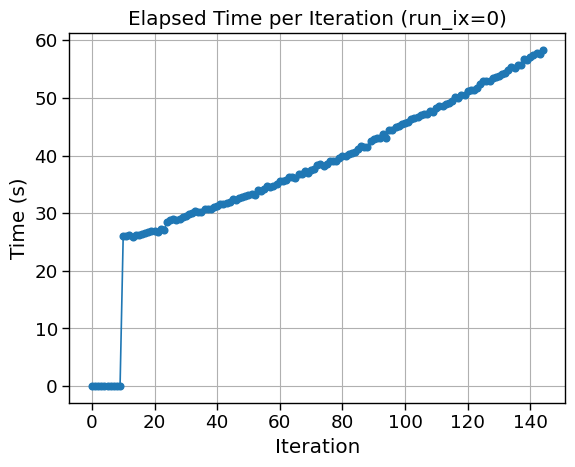

In [18]:
import matplotlib.pyplot as plt
# 첫번째 컬럼이 0인 것만 추출
filtered = [row for row in timing_data if row[0] == 0]

# 두번째 컬럼(x축), 세번째 컬럼(y축) 추출
x = [row[1] for row in filtered]
y = [row[2] for row in filtered]

plt.plot(x, y, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Elapsed Time per Iteration (run_ix=0)')
plt.grid(True)
plt.show()